In [1]:
import xarray as xr
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [2]:
ff = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df  = ff.drop(columns=['lat', 'lon', 'lsm', 'T1000', 'T700', 'EIS', 'ECTEI','ELF','SST', 'AOD'])
df = df[df.index.year.isin(np.arange(2003,2019))]
len(df)

5350237

In [3]:
data = df
index_train = data.index.year.isin(np.arange(2003,2015))
index_test  = data.index.year.isin(np.arange(2015,2019))
data_train = data[index_train]
data_test  = data[index_test]

X_train, y_train = data_train.iloc[:,1:], data_train.iloc[:,0]
X_test, y_test   = data_test.iloc[:,1:], data_test.iloc[:,0]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [4]:
#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
#!nvidia-smi
#!echo $CONDA_PREFIX
#!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2022-06-27 12:41:09.038642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 12:41:12.049049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30990 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1280      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 3

2022-06-27 12:44:30.806779: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/hpzhang/LCC_pred/data/NN_model/assets


INFO:tensorflow:Assets written to: /glade/work/hpzhang/LCC_pred/data/NN_model/assets


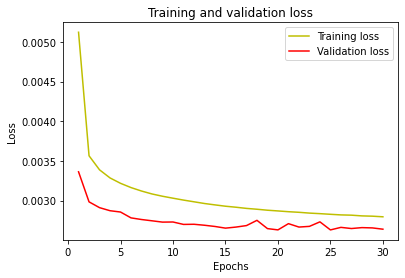

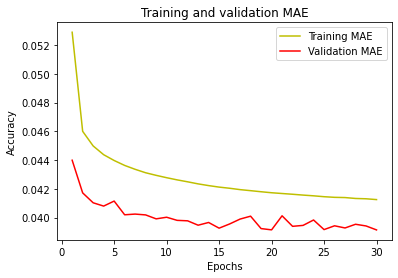

41869/41869 [==============================] - 45s 1ms/step - loss: 0.0027 - mae: 0.0395
Mean squared error from neural net:  0.0027213681023567915
Mean absolute error from neural net:  0.03952227905392647


In [5]:

### NNs, define the model
#Experiment with deeper and wider networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation


def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
get_custom_objects().update({'swish': Activation(swish)})

#with tf.device('/device:GPU:0'):
#GPUs = ["GPU:0","GPU:1"]
#strategy = tf.distribute.MirroredStrategy() #(GPUs)
#with strategy.scope():

model = Sequential()
initializer = tf.keras.initializers.HeUniform()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='swish', kernel_initializer=initializer))
model.add(Dense(64, activation='swish'))
model.add(Dense(64, activation='swish'))
model.add(Dense(32, activation='swish'))
model.add(Dense(32, activation='swish'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()
history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2, 
                    epochs =30,
                    batch_size=1024,
                    verbose = 1)

# save model
model.save('/glade/work/hpzhang/LCC_pred/data/NN_model')

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_neural = model.predict(X_test_scaled)

mse_neural, mae_neural = model.evaluate(X_test_scaled, y_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

In [6]:
### output ###

var = 'NN'
os.system("mkdir -p /glade/work/hpzhang/LCC_pred/data/{}".format(var))
np.save("/glade/work/hpzhang/LCC_pred/data/{}/loss.npy".format(var), np.array(history.history['loss']))
np.save("/glade/work/hpzhang/LCC_pred/data/{}/val_loss.npy".format(var), np.array(history.history['val_loss']))

np.save("/glade/work/hpzhang/LCC_pred/data/{}/mae.npy".format(var), np.array(history.history['mae']))
np.save("/glade/work/hpzhang/LCC_pred/data/{}/val_mae.npy".format(var), np.array(history.history['val_mae']))

np.save("/glade/work/hpzhang/LCC_pred/data/{}/y_pred_neural.npy".format(var), np.array(y_pred_neural))
